# Resultat de la question 4 du tp 1

## Import des biblio et du jeu de donnees pour l'entrainement

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import time

In [3]:
input_size = 28*28
n_classes = 10
n_epoch = 10 * 3
batch_size = 64
layer_size = 1000
learning_rate = 0.1
criterion_mse = nn.MSELoss()
criterion_ce = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# Téléchargement des données MNIST et application des transformations
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

# Chargement des données dans des chargeurs de données (dataloaders)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

## Fonctions et classes utilitaires

In [5]:
# MLPModel, sert à créer un modèle de réseau de neurones à couches entièrement connectées, aussi connu sous le nom de perceptron multicouche (MLP)
# avec un nombre spécifié de couches cachées (n_layers), chaque couche ayant un nombre spécifié de neurones (unit)
# la taille de l’entrée (input_size) et le nombre de classes de sortie (n_classes)
# et la possibilité d’utiliser ou non la fonction softmax en sortie (with_softmax)
class MLPModel(torch.nn.Module):

    def __init__(self, input_size, n_classes, n_layers, unit=1000, with_softmax = False, device='cpu'):
        super().__init__()
        self.layers = []
        for i in range(n_layers):
          if i == 0:
            layer = nn.Linear(input_size, unit).to(device)
          else:
            layer = nn.Linear(unit, unit).to(device)
          self.layers.append(layer)

        self.output_layer = nn.Linear(unit, n_classes).to(device)
        self.use_softmax = with_softmax
        self.input_size = input_size

    def forward(self, x):
        out = x.flatten(1)
        for layer in self.layers:## Import des biblio
            out = layer(out)
            out = torch.relu(out)
        out = self.output_layer(out)
        if self.use_softmax:
          out = F.log_softmax(out, dim=1)
        return out

In [6]:
# plot_training_curves, est utilisée pour visualiser les courbes d’apprentissage d’un modèle d’apprentissage automatique apres son entraînement
def plot_training_curves(train_losses, test_losses, train_accuracies, test_accuracies, num_epochs=1):
    print('\n')
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
    plt.plot(range(1, num_epochs+1), test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()
    plt.show()

    print('\n')
    print('-----------------------------------------------------------')
    print('\n')

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs+1), train_accuracies, label='Training Accuracy')
    plt.plot(range(1, num_epochs+1), test_accuracies, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Test Accuracy')
    plt.legend()
    plt.show()

In [7]:
# evaluate_model évalue la performance d’un modèle de réseau de neurones sur un ensemble de données donné (dataloader)
def evaluate_model(model, dataloader, criterion):
    model.eval()
    correct = 0
    total = 0
    losses = 0.0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            if isinstance(criterion, nn.MSELoss):
                target_test = F.one_hot(labels, num_classes=n_classes)
                labels = target_test.float()
            
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            loss = criterion(outputs, labels)
            losses += loss.item()
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return losses / len(dataloader) , 100 * correct / total

In [8]:
# run_epoch exécute une époque d’entraînement pour un modèle de réseau de neurones donné, en utilisant un ensemble de données (dataloader),
# une fonction de perte (criterion) et un optimiseur (optimizer).
# Elle renvoie la perte moyenne et la précision du modèle pour cette époque
def run_epoch(model, dataloader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    total = 0
    correct = 0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        if isinstance(criterion, nn.MSELoss):
            target_test = F.one_hot(labels, num_classes=n_classes)
            labels = target_test.float()

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if isinstance(criterion, nn.MSELoss):
            # Convert one-hot encoded labels to class indices
            labels_indices = torch.argmax(labels, dim=1)
            _, predicted_indices = torch.max(outputs, 1)
            correct += (predicted_indices == labels_indices).sum().item()
        else:
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()

        total += labels.size(0)

    epoch_loss = running_loss / len(dataloader)
    epoch_accuracy = 100 * correct / total

    return epoch_loss, epoch_accuracy

In [13]:
# train_model entraîne un modèle de machine learning sur plusieurs époques, enregistre les pertes et les précisions d’entraînement et de test,
# et ajuste le taux d’apprentissage si nécessaire. Elle affiche également les courbes d’apprentissage à la fin de l’entraînement
def train_model(model, optimizer, trainloader, testloader, criterion, num_epochs=2, learning_rate=0.1, use_lr_scheduler = False):
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []
    training_time = 0
    optimizer = optimizer(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, verbose=True)


    for epoch in range(num_epochs):

        start_gpu = time.time()

        train_loss, train_accuracy = run_epoch(model, trainloader, criterion, optimizer)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        test_loss, test_accuracy = evaluate_model(model, testloader, criterion)
        test_accuracies.append(test_accuracy)
        test_losses.append(test_loss)

        if use_lr_scheduler:
            scheduler.step(test_accuracy)

        end_gpu = time.time()
        training_time += end_gpu - start_gpu

        print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Test Loss: {test_loss}, Train Accuracy: {train_accuracy}, Test Accuracy: {test_accuracy} , Time: {end_gpu - start_gpu}s")

    print('\n')
    print('Training time: {:.2f}s'.format(training_time))

    plot_training_curves(train_losses, test_losses, train_accuracies, test_accuracies, num_epochs)

## Question 4 - a

Nous avons effectué plusieurs essais afin de trouver les hyperparamètres idéaux pour atteindre 100 % sur l'ensemble d'apprentissage.


Training with Cross Entropy Loss:
Epoch 1, Train Loss: 1.7012308046761861, Test Loss: 1.2761813872938703, Train Accuracy: 71.695, Test Accuracy: 80.55 , Time: 7.3283960819244385s
Epoch 2, Train Loss: 1.104165049122849, Test Loss: 0.9364862969726514, Train Accuracy: 80.89166666666667, Test Accuracy: 83.32 , Time: 7.043528079986572s
Epoch 3, Train Loss: 0.8747562301565589, Test Loss: 0.7778374643842126, Train Accuracy: 83.06, Test Accuracy: 84.96 , Time: 7.227677583694458s
Epoch 4, Train Loss: 0.7550600062745975, Test Loss: 0.6861932981925406, Train Accuracy: 84.28, Test Accuracy: 85.97 , Time: 7.324203968048096s
Epoch 5, Train Loss: 0.6805961453901933, Test Loss: 0.6258917483174877, Train Accuracy: 85.115, Test Accuracy: 86.62 , Time: 7.2329161167144775s
Epoch 6, Train Loss: 0.6288348874494211, Test Loss: 0.5815493916250338, Train Accuracy: 85.75, Test Accuracy: 87.13 , Time: 7.519643306732178s
Epoch 7, Train Loss: 0.590335227850912, Test Loss: 0.5482035216632163, Train Accuracy: 86.31

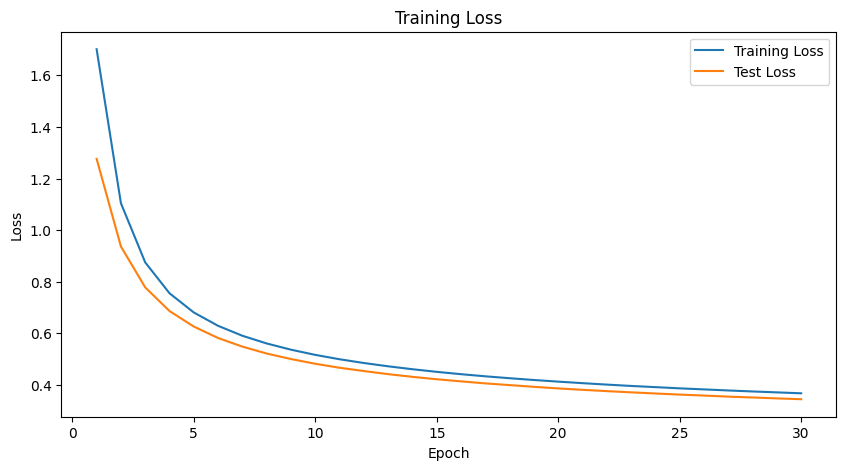



-----------------------------------------------------------




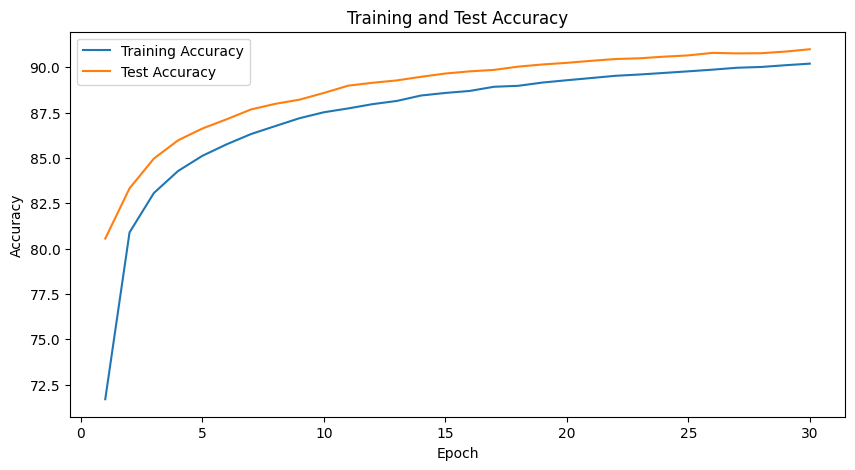

In [18]:
# Test avec l'optimiseur SGD, en utilisant trois couches de 1000 neurones et un lr de 0.1 sur 30 epochs
model = MLPModel(input_size, n_classes, 2, unit=layer_size, device=device).to(device)
optimizer = optim.SGD

print("\nTraining with Cross Entropy Loss:")
train_model(model,optimizer, trainloader, testloader, criterion_ce, num_epochs=n_epoch, learning_rate=learning_rate)


Training with Cross Entropy Loss:
Epoch 1, Train Loss: 1.219149939223393, Test Loss: 0.7541356561290231, Train Accuracy: 79.91166666666666, Test Accuracy: 85.91 , Time: 7.286471843719482s
Epoch 2, Train Loss: 0.6634214102967716, Test Loss: 0.5539263877899024, Train Accuracy: 86.45666666666666, Test Accuracy: 88.22 , Time: 7.199960708618164s
Epoch 3, Train Loss: 0.5351200747782233, Test Loss: 0.47289722996532535, Train Accuracy: 87.925, Test Accuracy: 89.25 , Time: 7.214624643325806s
Epoch 4, Train Loss: 0.47258987898892685, Test Loss: 0.4263520159159496, Train Accuracy: 88.79333333333334, Test Accuracy: 89.81 , Time: 7.1678149700164795s
Epoch 5, Train Loss: 0.43352156567738764, Test Loss: 0.3960835253167304, Train Accuracy: 89.39833333333333, Test Accuracy: 90.31 , Time: 7.275692462921143s
Epoch 6, Train Loss: 0.4062979934312133, Test Loss: 0.3733509188150145, Train Accuracy: 89.83166666666666, Test Accuracy: 90.86 , Time: 7.119422912597656s
Epoch 7, Train Loss: 0.3857297091595908, Te

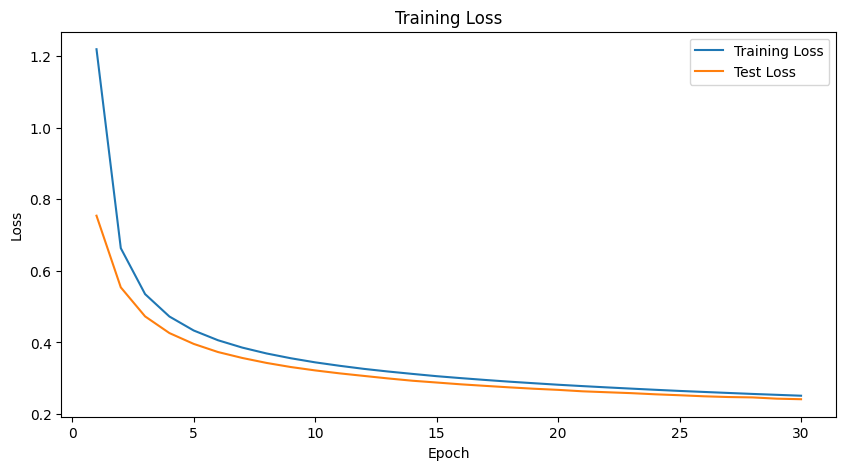



-----------------------------------------------------------




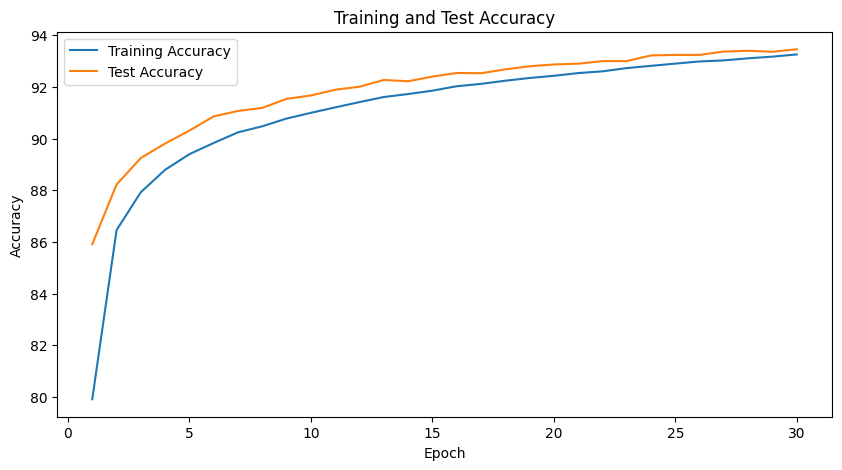

In [19]:
# Test avec l'optimiseur SGD, en utilisant trois couches de 3000 neurones et un lr de 0.1 sur 30 epochs
model = MLPModel(input_size, n_classes, 2, unit=layer_size*3, device=device).to(device)
optimizer = optim.SGD

print("\nTraining with Cross Entropy Loss:")
train_model(model,optimizer, trainloader, testloader, criterion_ce, num_epochs=n_epoch, learning_rate=learning_rate)


Training with Cross Entropy Loss:
Epoch 1, Train Loss: 0.29676615656105315, Test Loss: 0.2137268420003331, Train Accuracy: 90.96333333333334, Test Accuracy: 93.5 , Time: 7.224863767623901s
Epoch 2, Train Loss: 0.20650255623390712, Test Loss: 0.21381795905963488, Train Accuracy: 93.825, Test Accuracy: 93.69 , Time: 7.232184886932373s
Epoch 3, Train Loss: 0.18555528982115516, Test Loss: 0.2910985732095162, Train Accuracy: 94.595, Test Accuracy: 92.51 , Time: 7.3599207401275635s
Epoch 4, Train Loss: 0.1764474120224391, Test Loss: 0.22974688327032627, Train Accuracy: 94.96833333333333, Test Accuracy: 93.99 , Time: 7.338465690612793s
Epoch 5, Train Loss: 0.1652601674593278, Test Loss: 0.21654220539994928, Train Accuracy: 95.27833333333334, Test Accuracy: 94.46 , Time: 7.438357353210449s
Epoch 6, Train Loss: 0.16411220536245577, Test Loss: 0.23162386242550898, Train Accuracy: 95.45333333333333, Test Accuracy: 93.86 , Time: 7.1576361656188965s
Epoch 7, Train Loss: 0.16001823908293933, Test L

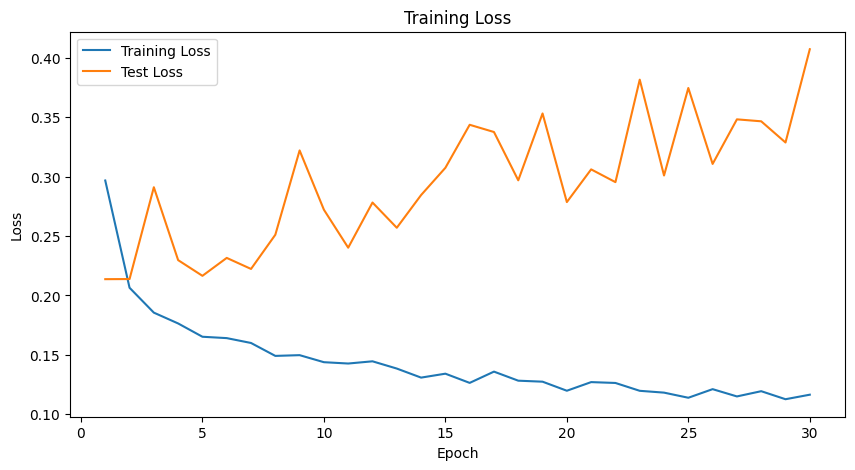



-----------------------------------------------------------




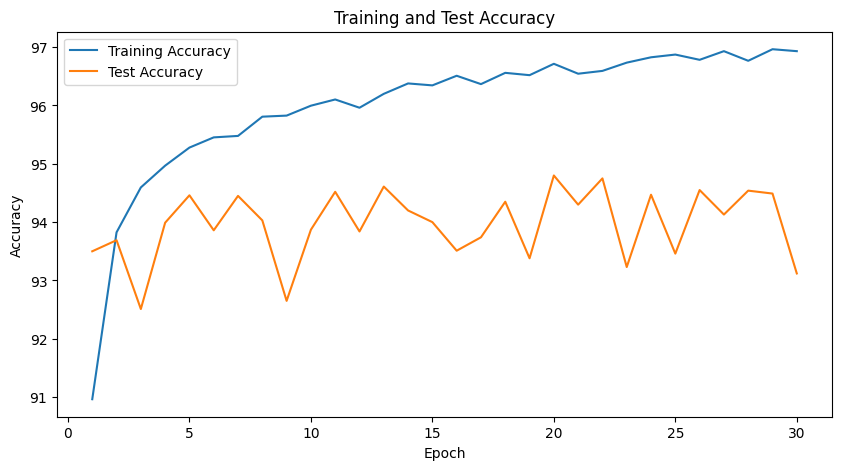

In [20]:
# Test avec l'optimiseur Adam, en utilisant trois couches de 1000 neurones et un lr de 0.1 sur 30 epochs
model = MLPModel(input_size, n_classes, 2, unit=layer_size*1, device=device).to(device)
optimizer = optim.Adam

print("\nTraining with Cross Entropy Loss:")
train_model(model,optimizer, trainloader, testloader, criterion_ce, num_epochs=n_epoch, learning_rate=learning_rate)


Training with Cross Entropy Loss:
Epoch 1, Train Loss: 0.42115291694540585, Test Loss: 0.3201141398537987, Train Accuracy: 90.285, Test Accuracy: 93.23 , Time: 7.395231008529663s
Epoch 2, Train Loss: 0.27501964606982626, Test Loss: 0.2858802960642141, Train Accuracy: 94.34, Test Accuracy: 95.02 , Time: 7.3979198932647705s
Epoch 3, Train Loss: 0.2576866585046186, Test Loss: 0.2674851042059178, Train Accuracy: 95.185, Test Accuracy: 96.05 , Time: 7.465474843978882s
Epoch 4, Train Loss: 0.22281814877991998, Test Loss: 0.3293347415482839, Train Accuracy: 95.97666666666667, Test Accuracy: 95.31 , Time: 7.429360389709473s
Epoch 5, Train Loss: 0.2323081269604271, Test Loss: 0.32589151218028334, Train Accuracy: 96.16166666666666, Test Accuracy: 95.72 , Time: 7.319089412689209s
Epoch 6, Train Loss: 0.18562043137711084, Test Loss: 0.3416127982972175, Train Accuracy: 96.90333333333334, Test Accuracy: 95.87 , Time: 7.322886943817139s
Epoch 7, Train Loss: 0.17915371066822267, Test Loss: 0.44676170

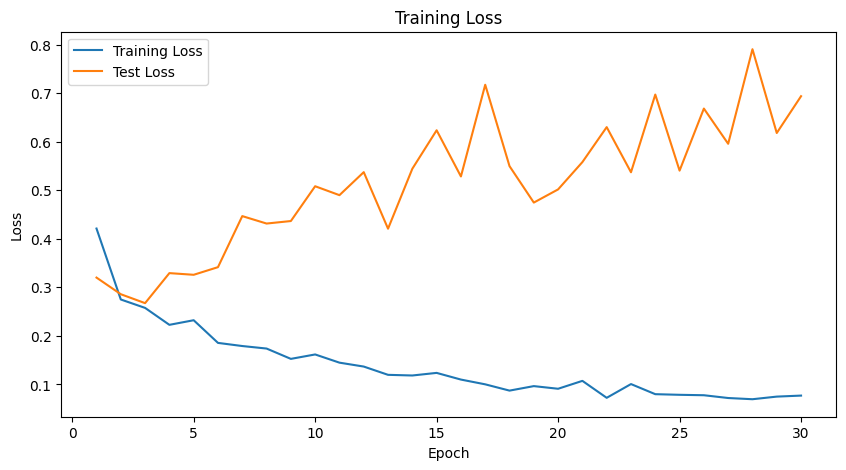



-----------------------------------------------------------




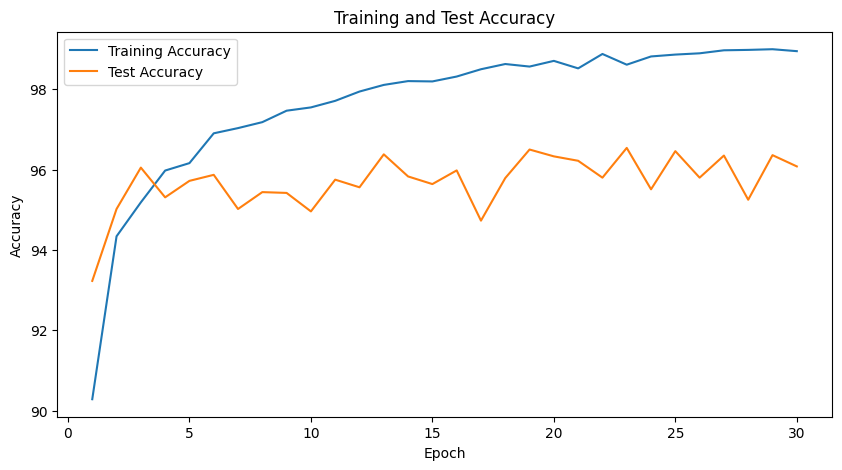

In [21]:
# Test avec l'optimiseur Adam, en utilisant trois couches de 3000 neurones et un lr de 0.1 sur 30 epochs
model = MLPModel(input_size, n_classes, 2, unit=layer_size*3, device=device).to(device)
optimizer = optim.Adam

print("\nTraining with Cross Entropy Loss:")
train_model(model,optimizer, trainloader, testloader, criterion_ce, num_epochs=n_epoch, learning_rate=learning_rate)


Training with Cross Entropy Loss:
Epoch 1, Train Loss: 0.5382372064837145, Test Loss: 0.2618135916763077, Train Accuracy: 89.88333333333334, Test Accuracy: 95.22 , Time: 7.641554355621338s
Epoch 2, Train Loss: 0.3594541875843629, Test Loss: 0.4377261897161501, Train Accuracy: 94.16333333333333, Test Accuracy: 93.89 , Time: 7.676085710525513s
Epoch 3, Train Loss: 0.3044897584614271, Test Loss: 0.5197108069725314, Train Accuracy: 95.325, Test Accuracy: 93.87 , Time: 7.679236650466919s
Epoch 4, Train Loss: 0.3047328867787132, Test Loss: 0.569810610119536, Train Accuracy: 95.88666666666667, Test Accuracy: 94.52 , Time: 7.762063980102539s
Epoch 00005: reducing learning rate of group 0 to 1.0000e-02.
Epoch 5, Train Loss: 0.26096931095312736, Test Loss: 0.5790745899735903, Train Accuracy: 96.49333333333334, Test Accuracy: 94.36 , Time: 7.59425163269043s
Epoch 6, Train Loss: 0.06622964882226823, Test Loss: 0.25044840764825727, Train Accuracy: 98.88, Test Accuracy: 97.16 , Time: 7.549894571304

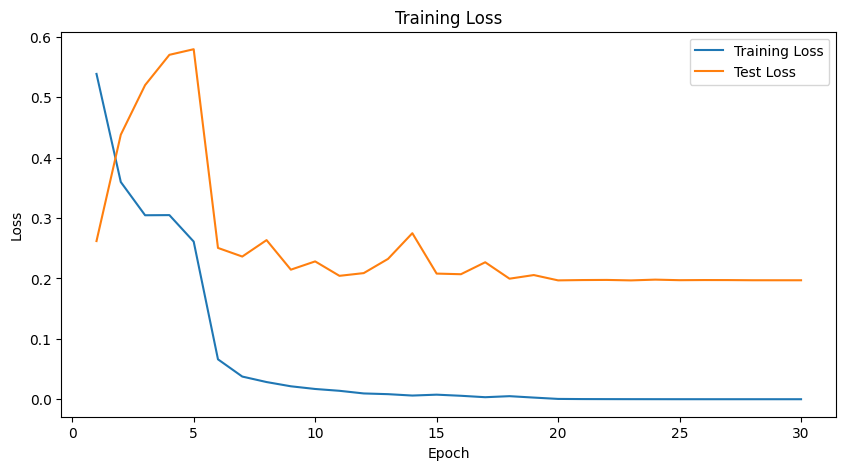



-----------------------------------------------------------




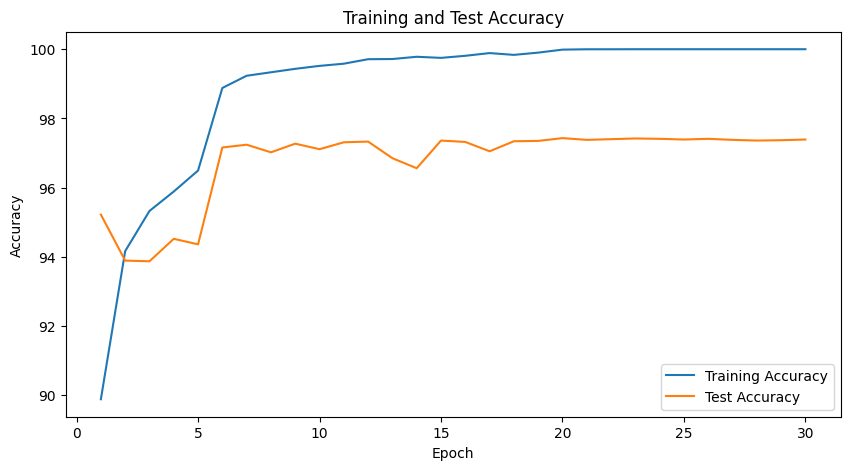

In [17]:
# Test avec l'optimiseur Adam, en utilisant trois couches de 4000 neurones et un lr (reduit au fil des epochs en fonction de l'accuracy au test) de 0.1 sur 30 epochs
model = MLPModel(input_size, n_classes, 2, unit=layer_size * 4, device=device).to(device)
optimizer = optim.Adam

print("\nTraining with Cross Entropy Loss:")
train_model(model,optimizer, trainloader, testloader, criterion_ce, num_epochs=n_epoch, learning_rate=learning_rate, use_lr_scheduler=True)

Avec ce dernier entraînement, nous avons finalement atteint une précision de 100 % sur l'ensemble d'entraînement MNIST avec un taux d'erreur de 2.6%.

## Question 4 - b

Oui, le modèle obtenu précédemment semble faire de l'overfitting. parce que la précision de l'entraînement continue d'augmenter puis reste constante, tandis que la précision de la validation chute quelques fois pour les premiers epochs, puis stagne et ne s'améliore plus. Cela indique que le modèle apprend bien les données d'entraînement, mais ne généralise pas bien aux données de validation.

## Question 4 - c

Entraînement avec la Mean Square Error torch.nn.MSELoss, sur la sortie du réseau (sans softmax) avec les mêmes hyperparamètres qui ont donné 100% sur l'ensemble d'entraînement, mais avec un lr fixe de 0.1

Training with MSE Loss:
Epoch 1, Train Loss: 0.509757811312816, Test Loss: 0.46762543919659, Train Accuracy: 90.26666666666667, Test Accuracy: 91.8 , Time: 7.687751054763794s
Epoch 2, Train Loss: 0.3408082720207007, Test Loss: 0.42367172193996, Train Accuracy: 94.24166666666666, Test Accuracy: 94.01 , Time: 7.793035984039307s
Epoch 3, Train Loss: 0.323873760512972, Test Loss: 0.3276137265818091, Train Accuracy: 95.31166666666667, Test Accuracy: 95.77 , Time: 7.676104784011841s
Epoch 4, Train Loss: 0.266884849466853, Test Loss: 0.52087117674682, Train Accuracy: 96.19833333333334, Test Accuracy: 94.45 , Time: 7.666521787643433s
Epoch 5, Train Loss: 0.25121799757487573, Test Loss: 0.3830478686894166, Train Accuracy: 96.47666666666667, Test Accuracy: 95.96 , Time: 7.642714500427246s
Epoch 6, Train Loss: 0.2593470748080026, Test Loss: 0.4350836006216996, Train Accuracy: 96.67666666666666, Test Accuracy: 95.86 , Time: 7.601813316345215s
Epoch 7, Train Loss: 0.2071542247373941, Test Loss: 0.5

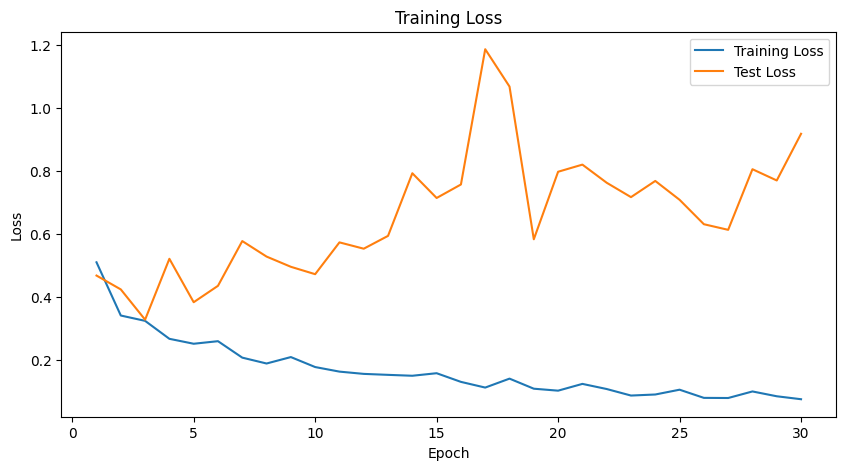



-----------------------------------------------------------




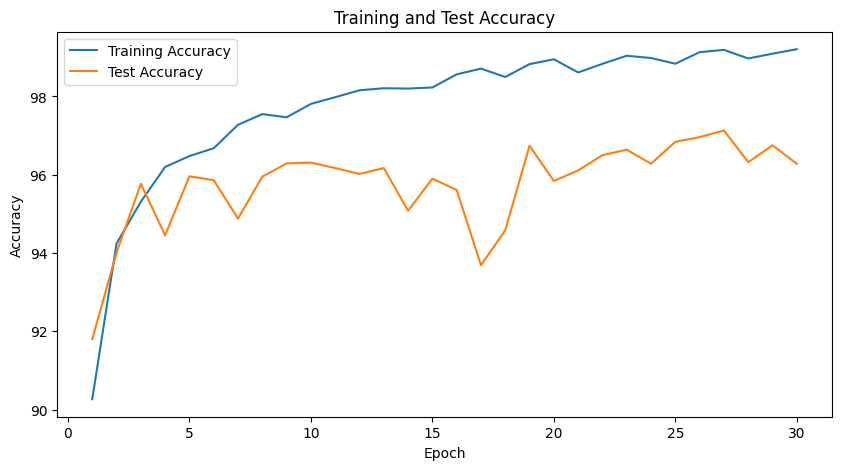

In [23]:
model = MLPModel(input_size, n_classes, 2, unit=layer_size*4, with_softmax=False, device=device).to(device)
optimizer = optim.Adam

print("Training with MSE Loss:")
train_model(model,optimizer, trainloader, testloader, criterion_ce, num_epochs=n_epoch, learning_rate=learning_rate)

Entraînement avec la Mean Square Error torch.nn.MSELoss, sur la sortie du réseau (avec softmax) avec les mêmes hyperparamètres qui ont donné 100% sur l'ensemble d'entraînement, mais avec un lr fixe de 0.1

Training with MSE Loss:
Epoch 1, Train Loss: 0.5382844253998202, Test Loss: 0.3903588028388301, Train Accuracy: 90.03, Test Accuracy: 93.1 , Time: 7.631360769271851s
Epoch 2, Train Loss: 0.32519105868649856, Test Loss: 0.5635639849995057, Train Accuracy: 94.34166666666667, Test Accuracy: 91.89 , Time: 7.595679998397827s
Epoch 3, Train Loss: 0.30135554820128496, Test Loss: 0.5082035656938515, Train Accuracy: 95.27833333333334, Test Accuracy: 93.65 , Time: 7.6801981925964355s
Epoch 4, Train Loss: 0.2796243452152153, Test Loss: 0.4366816459321158, Train Accuracy: 95.915, Test Accuracy: 95.45 , Time: 7.549232482910156s
Epoch 5, Train Loss: 0.26040734598240173, Test Loss: 0.3689239178295348, Train Accuracy: 96.45833333333333, Test Accuracy: 96.25 , Time: 7.627318382263184s
Epoch 6, Train Loss: 0.21583311844987044, Test Loss: 0.36906101165045596, Train Accuracy: 97.01, Test Accuracy: 96.44 , Time: 7.651196002960205s
Epoch 7, Train Loss: 0.2178163599327226, Test Loss: 0.48790377837138893, Tra

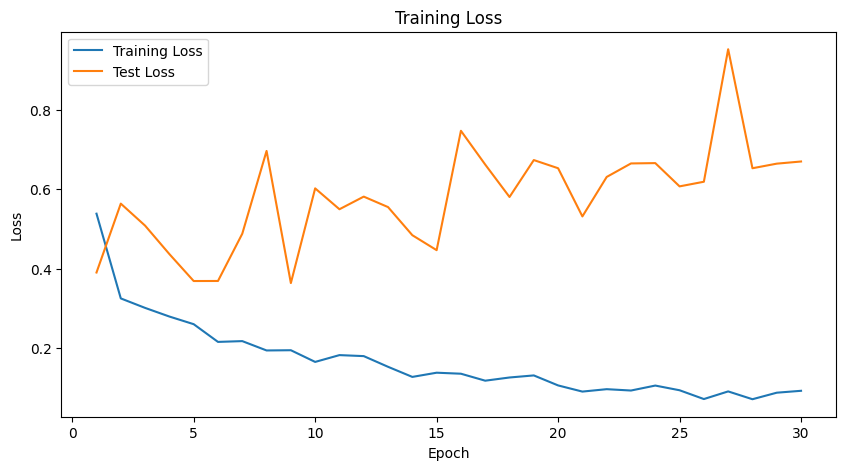



-----------------------------------------------------------




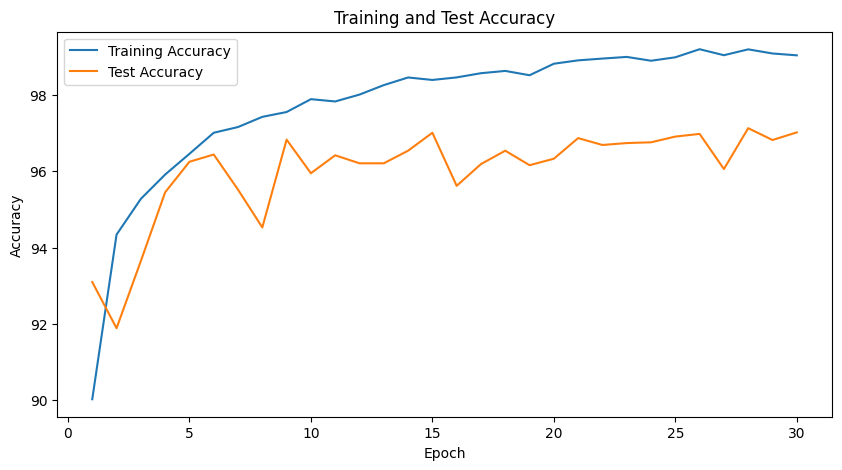

In [25]:
model = MLPModel(input_size, n_classes, 2, unit=layer_size*4, with_softmax=True, device=device).to(device)
optimizer = optim.Adam

print("Training with MSE Loss:")
train_model(model,optimizer, trainloader, testloader, criterion_ce, num_epochs=n_epoch, learning_rate=learning_rate)

Temps d'execution:
- Training time sans softmax : 229.94s
- Training time avec softmax: 229.15s

En comparant les deux résultats, voici nos observations :

- Vitesse d’entraînement : Dans les deux cas, le modèle s’entraîne rapidement avec une diminution rapide de la perte d’entraînement pendant les premières époques. Cependant, dans le cas avec la fonction softmax, la perte semble se stabiliser après environ 25 époques, tandis que dans le cas sans softmax, elle se stabilise après environ 15 époques. Cela pourrait indiquer que la fonction softmax a permis au modèle de continuer à apprendre et à s’ajuster pendant une période plus longue.

- Résultat final : Dans les deux cas, il y a une divergence entre les précisions d’entraînement et de test après un certain nombre d’époques, ce qui pourrait indiquer un surapprentissage. Cependant, cette divergence semble être plus prononcée dans le cas sans softmax, ce qui suggère que le surapprentissage pourrait être plus sévère dans ce cas.

- Précisions pour les ensembles d’entraînement et de test : Dans les deux cas, la précision d’entraînement est supérieure à la précision de test, ce qui est une indication de surapprentissage. Cependant, cette différence semble être plus grande dans le cas sans softmax.